# Import Object

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from models import AttentionRNN
from train_model import train_timeseries_net

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [3]:
train_x = pd.read_csv("./data/win2_X_train.csv").values
train_y = pd.read_csv("./data/win2_Y_train.csv").values.reshape(-1)

ss = preprocessing.StandardScaler()
train_x = ss.fit_transform(train_x)

num_days = int(train_x.shape[0] / 16)
train_x = train_x.reshape(num_days, 16, 11)
train_y = train_y.reshape(num_days, 16, 1)
train_x, test_x, train_y, test_y = train_test_split(train_x,
                                                    train_y,
                                                    test_size=0.2,
                                                    shuffle=True)

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.int64)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.int64)

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

train_ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=6, shuffle=True)

# Set Free Parameters

In [4]:
input_size = 11
num_layers = 1
hidden_size = 100
num_classes = 2
learning_rate = 0.0001
num_epochs = 150
dropout_ratio = 0.5

# Instantiate Model, Criterion, Optimizer

In [5]:
model = AttentionRNN(input_size, hidden_size,
                     num_layers, num_classes, dropout_ratio).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=1e-3, eps=1e-11)

# Training

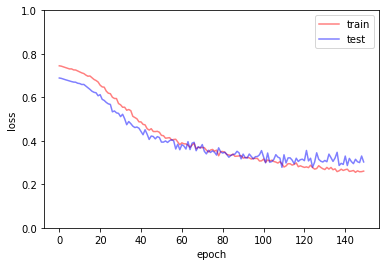

In [6]:
model = train_timeseries_net(model, criterion, optimizer,
                             num_epochs, train_loader, test_x,
                             test_y, device)

# Accuracy

In [7]:
score_y = model(test_x, device).reshape(-1, 2)
_, pred_y = score_y.max(1)
test_y = test_y.reshape(-1)
print(sum(pred_y == test_y) / int(test_y.shape[0]))

tensor(0.9125, device='cuda:0')
